In [23]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [114]:
df = pd.read_csv('pitches_final_simplified.csv', index_col = 0)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [115]:
df.head()

,game_date,release_speed,player_name,description,zone,type,balls,strikes,plate_x,plate_z,...,pitch_name,bat_score,fld_score,reg_season,post_season,p_left,p_right,bat_left,bat_right,prev_pitch
0,2015-04-05,90.1,Adam Wainwright,ball,13,B,0,0,-1.585,1.720,...,Fastball,0,1,1,0,0,1,1,0,None
1,2015-04-05,88.1,Adam Wainwright,hit_into_play_no_out,5,X,1,0,0.008,2.602,...,Fastball,0,1,1,0,0,1,1,0,Fastball
2,2015-04-05,92.2,Adam Wainwright,foul,5,S,0,0,0.015,2.287,...,Fastball,0,1,1,0,0,1,0,1,None
3,2015-04-05,76.6,Adam Wainwright,blocked_ball,14,B,0,1,1.703,0.220,...,Breaking Ball,0,1,1,0,0,1,0,1,Fastball
4,2015-04-05,89.9,Adam Wainwright,hit_into_play,9,X,1,2,0.788,1.808,...,Fastball,0,1,1,0,0,1,0,1,Breaking Ball


In [116]:
kershaw = df[df['player_name']=='Max Scherzer']

In [117]:
# Naturally expect a class imbalance for pitchers
kershaw['pitch_name'].value_counts()

Fastball         9910
Breaking Ball    4758
Off-speed        2389
Name: pitch_name, dtype: int64

In [118]:
# Drop intentional balls and pitch outs, they aren't real pitches and batters don't need to worry about them
kershaw.drop(kershaw[kershaw['pitch_name']=='Intentional Ball'].index, inplace=True, errors = 'ignore')
kershaw.drop(kershaw[kershaw['pitch_name']=='Pitch Out'].index, inplace=True, errors = 'ignore')

# Unable to classify/do regression with classes with only 1 instance
# so drop the rows with that pitch as well as the row w/ corresponding 'prev_pitch'
for i in range(len(kershaw['pitch_name'].value_counts())):
    if kershaw['pitch_name'].value_counts()[i] == 1:
        drop = kershaw['pitch_name'].value_counts().index[i]
        kershaw.drop(kershaw[kershaw['pitch_name']==drop].index, inplace=True)
        kershaw.drop(kershaw[kershaw['prev_pitch']==drop].index, inplace=True)

kershaw.drop(['game_date', 'description'], axis = 1, inplace = True)

# Drop release_speed since this isn't a predicative feature for guessing pitches prior to the pitch being thrown
kershaw.drop(['release_speed'], axis = 1, inplace = True)

# Drop other non pre-pitch predicative stuff
kershaw.drop(['type', 'plate_x', 'plate_z'], axis = 1, inplace = True)

kershaw.drop(['player_name', 'at_bat_number'], axis = 1, inplace = True)

balls = pd.get_dummies(kershaw['balls'], prefix = 'b_')

strikes = pd.get_dummies(kershaw['strikes'], prefix = 's_')

prev = pd.get_dummies(kershaw['prev_pitch'], prefix= 'prev_')

X = pd.concat([kershaw, balls, strikes, prev], axis = 1)
X.drop(['balls', 'strikes', 'prev_pitch'], axis = 1, inplace = True)

# X.drop(['pitch_name'], axis = 1, inplace = True)

X.drop(['sz_top', 'sz_bot'], axis = 1, inplace = True)

X['early'] = np.where(X['inning'] <= 3, 1, 0)
X['mid'] = np.where((X['inning'] <= 6) & (X['inning'] > 3), 1, 0)
X['late'] = np.where((X['inning'] <= 9) & (X['inning'] > 6), 1, 0)

X.drop(['inning'], axis = 1, inplace = True)

X.drop(['pitch_number'], axis = 1, inplace = True)

X.drop(['zone'], axis = 1, inplace = True)

C:\ProgramData\Anaconda\envs\capstone\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [119]:
X1 = X.drop(['pitch_name'], axis = 1)
y = X['pitch_name']

In [120]:
from sklearn.model_selection import train_test_split

# Split with stratification given the class imbalance
X_train, X_test, y_train, y_test = train_test_split(X1, y, stratify = y, test_size=0.25)

In [121]:
print(y_train.value_counts())
print(y_test.value_counts())

Fastball         7432
Breaking Ball    3568
Off-speed        1792
Name: pitch_name, dtype: int64
Fastball         2478
Breaking Ball    1190
Off-speed         597
Name: pitch_name, dtype: int64


In [122]:
# Convert output to an array
pitch = pd.get_dummies(y_train.copy())
y_train = pitch.values

In [123]:
pitch = pd.get_dummies(y_test.copy())
y_test = pitch.values

In [124]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12792, 26)
(12792, 3)
(4265, 26)
(4265, 3)


In [125]:
opt = tf.keras.optimizers.Adam(lr=0.0001)

In [133]:
# Want a reasonable number of epochs for running/adjusting to different pitchers

# Make sure to reset model before running each time
input_layer = Input(shape = (X_train.shape[1], ))
dense_layer_1 = Dense(512, activation='relu')(input_layer)
drop_layer_1 = tf.keras.layers.Dropout(.2)(dense_layer_1)
dense_layer_2 = Dense(128, activation='relu')(drop_layer_1)
drop_layer_2 = tf.keras.layers.Dropout(.2)(dense_layer_2)
dense_layer_3 = Dense(128, activation='relu')(drop_layer_2)
drop_layer_3 = tf.keras.layers.Dropout(.2)(dense_layer_3)
dense_layer_4 = Dense(64, activation='relu')(drop_layer_3)
# Output shape equals to number of classes (columns) in y
output = Dense(y_train.shape[1], activation='softmax')(dense_layer_4)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

history = model.fit(X_train, y_train, batch_size=25, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
410/410 [==============================] - 2s 4ms/step - loss: 0.9132 - acc: 0.5816 - val_loss: 0.8846 - val_acc: 0.5744
Epoch 2/30
410/410 [==============================] - 1s 3ms/step - loss: 0.8848 - acc: 0.5839 - val_loss: 0.8786 - val_acc: 0.5698
Epoch 3/30
410/410 [==============================] - 1s 3ms/step - loss: 0.8764 - acc: 0.5824 - val_loss: 0.8729 - val_acc: 0.5826
Epoch 4/30
410/410 [==============================] - 1s 3ms/step - loss: 0.8737 - acc: 0.5820 - val_loss: 0.8718 - val_acc: 0.5791
Epoch 5/30
410/410 [==============================] - 1s 3ms/step - loss: 0.8719 - acc: 0.5891 - val_loss: 0.8727 - val_acc: 0.5850
Epoch 6/30
410/410 [==============================] - 1s 3ms/step - loss: 0.8689 - acc: 0.5840 - val_loss: 0.8717 - val_acc: 0.5795
Epoch 7/30
410/410 [==============================] - 1s 3ms/step - loss: 0.8686 - acc: 0.5848 - val_loss: 0.8700 - val_acc: 0.5795
Epoch 8/30
410/410 [==============================] - 1s 3ms/step - loss: 0.

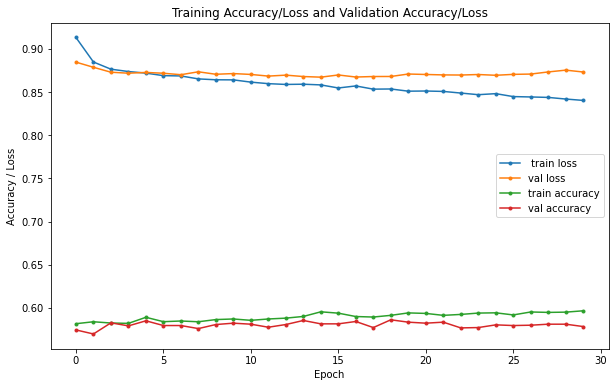

In [134]:
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'], marker='o', markersize = 3, label=' train loss')
plt.plot(history.history['val_loss'], marker='o', markersize = 3, label='val loss')
plt.plot(history.history['acc'], marker='o', markersize = 3, label='train accuracy')
plt.plot(history.history['val_acc'], marker='o', markersize = 3, label='val accuracy')
plt.title('Training Accuracy/Loss and Validation Accuracy/Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.show()

In [135]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

134/134 [==============================] - 0s 1ms/step - loss: 0.8672 - acc: 0.5831
Test Loss: 0.8671820759773254
Test Accuracy: 0.5831183791160583


In [136]:
predictions = model.predict(X_test)
pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns


# Transform confusion matrix to df
cols = list(xnames)
for x in range(len(cols)):
    cols[x] = 'Pred_' + cols[x]
confusion_df = pd.DataFrame(confusion_matrix(actual_pitch,pred_pitch), columns=cols)
# Add column w/ sum of actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)
# Add row of sum of predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)
# Add detailed index names
indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]
indices.append('Sum of Predictions')
confusion_df.index=indices
confusion_df

,Pred_Breaking Ball,Pred_Fastball,Pred_Off-speed,Sum of Actuals
Actual_Breaking Ball,287,893,10,1190
Actual_Fastball,273,2184,21,2478
Actual_Off-speed,71,510,16,597
Sum of Predictions,631,3587,47,4265


In [139]:
from sklearn.metrics import f1_score

f1_score(actual_pitch, pred_pitch, average = 'weighted')

0.5133450122733121

In [140]:
from sklearn.metrics import classification_report

actual_pitch = np.where(actual_pitch == 0, xnames.values[0], 
                        np.where(actual_pitch == 1, xnames.values[1], 
                                 np.where(actual_pitch == 2, xnames.values[2], actual_pitch)))

pred_pitch = np.where(pred_pitch == 0, xnames.values[0], 
                        np.where(pred_pitch == 1, xnames.values[1], 
                                 np.where(pred_pitch == 2, xnames.values[2], pred_pitch)))

report_initial = classification_report(actual_pitch, pred_pitch)
print(report_initial)

               precision    recall  f1-score   support

Breaking Ball       0.45      0.24      0.32      1190
     Fastball       0.61      0.88      0.72      2478
    Off-speed       0.34      0.03      0.05       597

     accuracy                           0.58      4265
    macro avg       0.47      0.38      0.36      4265
 weighted avg       0.53      0.58      0.51      4265



In [131]:
# 50 epochs
# Precision: How accurate are our claims?

pfb = 2119/3473
pbb = 328/729
pof = 19/63

sum = pfb+pbb+pof
sum

1.3616540441678278

In [137]:
# 30 epochs
# Precision: How accurate are our claims?

pfb = 2184/3587
pbb = 287/631
pof = 16/47

sum = pfb+pbb+pof
sum

1.404124476465938

In [132]:
# 50 epochs
# Recall: Of all true class 1 data points, how many were we able to recall?
# RECALL is more important: want to be able to get as many of the correct pitches as possible

rfb = 2119/2478
rbb = 328/1190
ros = 19/597

sum = rfb + rbb + ros
sum

1.1625811486335442

In [138]:
# 30 epochs
# Recall: Of all true class 1 data points, how many were we able to recall?
# RECALL is more important: want to be able to get as many of the correct pitches as possible

rfb = 2184/2478
rbb = 287/1190
ros = 16/597

sum = rfb + rbb + ros
sum

1.1493330728083755

In [ ]:
predictions = model.predict(X_test)

xnames = pitch.columns

indices = np.arange(len(pitch.columns))
width = 0.3

for i in np.arange(15):
    plt.bar(indices-width/2, predictions[i], width, label = 'pred')
    plt.bar(indices + width/2, y_test[i], width, label = 'actual')
    plt.ylabel('Probability')
    plt.xlabel('Pitch Type')
    plt.legend()
    plt.xticks(indices, xnames, rotation=90)
    plt.show()

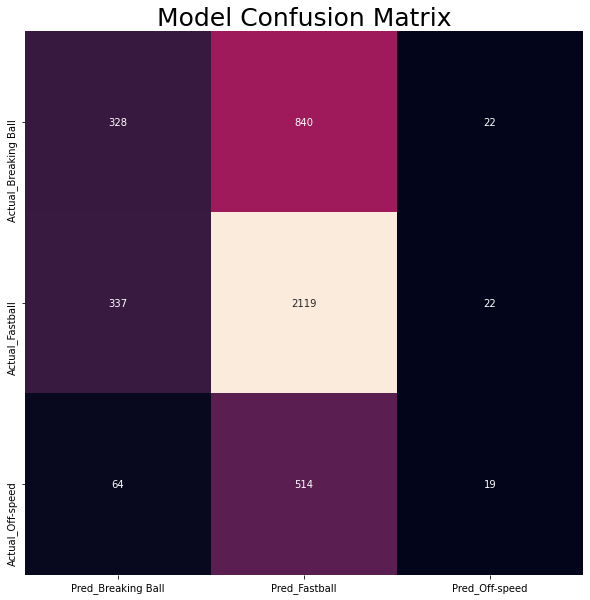

In [130]:
pred_pitch = np.argmax(predictions,axis=1)
actual_pitch = np.argmax(y_test, axis = 1)
xnames = pitch.columns

indices = list(xnames)
for x in range(len(indices)):
    indices[x] = 'Actual_' + indices[x]

conf_mat = confusion_matrix(actual_pitch,pred_pitch)
plt.figure(figsize = (10,10))
sns.heatmap(conf_mat,
            annot=True,
            fmt="g",
            xticklabels=cols,
            yticklabels=indices,
            cbar=False
           )
plt.title('Model Confusion Matrix',size = 25,y=1.01)
plt.show()

In [ ]:


xnames = pitch.columns

indices = np.arange(len(pitch.columns))
width = 0.3

for i in np.arange(15):
    plt.bar(indices-width/2, predictions[i], width, label = 'pred')
    plt.bar(indices + width/2, y_test[i], width, label = 'actual')
    plt.ylabel('Probability')
    plt.xlabel('Pitch Type')
    plt.legend()
    plt.xticks(indices, xnames, rotation=90)
    plt.show()

---